In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

#### On créé des données factices avec lesquelles on va travailler

In [2]:
np.random.seed(0) # Utiliser une nouvelle seed pour la reproductibilité

N_SAMPLES = 1000

# Génération des features X
humidite = np.random.uniform(40, 80, N_SAMPLES)  # Humidité relative en pourcentage
pression = np.random.uniform(5, 90, N_SAMPLES)  # Pression atmosphérique en hPa
precipitations = np.random.uniform(0, 20, N_SAMPLES)  # Précipitations en millimètres

# Introduction de corrélation dans le modèle
W_humidite = 0.25
W_pression = -0.3
W_precipitations = -0.5
BIAS = 20.0

# Calcul de la target (température)
target_temperature_deterministe = (
    BIAS +
    (W_humidite * humidite) +
    (W_pression * pression) +
    (W_precipitations * precipitations)
)

# Ajout du bruit pour rendre les données plus réalistes (pas de corrélation parfaite).
NOISE_STD = 5.0
bruit = np.random.normal(0, NOISE_STD, N_SAMPLES)

# La cible finale est la partie déterministe + le bruit
temperature_finale = target_temperature_deterministe + bruit

# Création du DataFrame
data = pd.DataFrame({
    'Temperature': temperature_finale,
    'Humidite': humidite,
    'Pression': pression,
    'Precipitations': precipitations
})

data.head()

,Temperature,Humidite,Pression,Precipitations
0,19.756817,61.952540,55.394823,16.230369
1,24.658911,68.607575,5.855414,9.521680
2,19.745043,64.110535,45.445227,10.463120
3,15.416456,61.795327,65.245483,5.010412
4,23.469334,56.946192,8.737912,12.100860


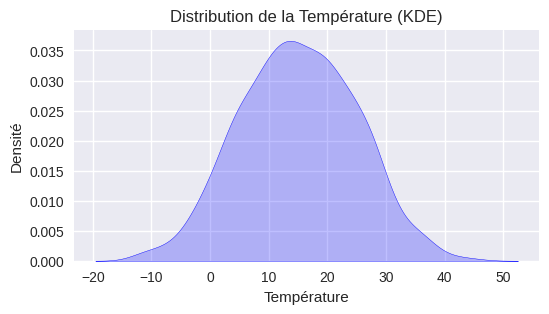

In [3]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=data, x='Temperature', fill=True, color='blue')
plt.title("Distribution de la Température (KDE)")
plt.xlabel("Température")
plt.ylabel("Densité")
plt.show()

#### Découpage en jeu de train et de validation (80% / 20%)

In [4]:
X = data.loc[:799, ['Humidite', 'Pression', 'Precipitations']].values
y = data.loc[:799, 'Temperature'].values

In [5]:
X_val = data.loc[800:, ['Humidite', 'Pression', 'Precipitations']].values
y_val = data.loc[800:, 'Temperature'].values

In [6]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(800, 3) (800,) (200, 3) (200,)


#### On créé une fonction qui nous permet de scaler nos données numériques

In [7]:
def standardize_data(X):
    return (X - np.mean(X)) / np.std(X)

In [8]:
X_scaled = standardize_data(X)
X_scaled

array([[ 0.83439825,  0.59069388, -0.86477432],
       [ 1.08171923, -1.25033868, -1.11408928],
       [ 0.9145958 ,  0.22093713, -1.07910256],
       ...,
       [ 0.37857945,  0.49037075, -0.92233443],
       [ 0.39079808,  1.36040211, -0.83024239],
       [ 0.73715019, -0.40380827, -1.13102069]])

In [9]:
X_val_scaled = (X_val - np.mean(X)) / np.std(X) # On utilise la moyenne et l'écart-type de X pour scaler X_val

#### Les calculs à implémanter

Pour rappel, notre fonction coût (la MSE) vaut :

$$MSE(W) = \frac{1}{n_{rows}} \sum_{i=1}^{n_{rows}} (\hat{y}_i - y_i)^2$$

Il faut procéder au calcul du gradient pour mettre à jour les paramètres du modèle (pour qu'il apprenne de ces erreurs).

La gradient correspond à la dérivée partielle de la fonction coût par rapport à ses paramètres. Voici la formule du gradient pour la MSE :

$$\frac{\partial MSE(W)}{\partial w_j} = \frac{2}{n_{rows}} \sum_{i=1}^{n_{rows}} x_{i,j}(\hat{y}_i - y_i)$$

####Pour les curieux qui veulent comprendre comment on obtient ce résultat :

<br>
On cherche à calculer la dérivée partielle de la MSE par rapport au paramètre $w_j$ :

$$\frac{\partial MSE(W)}{\partial w_j} = \frac{\partial}{\partial w_j} \left[ \frac{1}{n_{rows}} \sum_{i=1}^{n_{rows}} (\hat{y}_i - y_i)^2 \right]$$<br>

On peut simplifier en déplaçant l'opérateur de dérivation :    

$$\frac{\partial MSE(W)}{\partial w_j} = \frac{1}{n_{rows}} \sum_{i=1}^{n_{rows}} \frac{\partial}{\partial w_j} (\hat{y}_i - y_i)^2$$<br>

Concentrons nous sur la partie à dériver :    

 $$\frac{\partial}{\partial w_j} (\hat{y}_i - y_i)^2$$  <br>


Nous devons dériver la fonction $f(u) = u^2$, où $u = (\hat{y}_i - y_i)$.

Il s'agit d'une fonction composée (une fonction à l'intérieur d'une autre fonction).

La règle de dérivation en chaîne est : $\frac{\partial f(u)}{\partial w_j} = \frac{df}{du} \mathbf{\times} \frac{\partial u}{\partial w_j}$



On obtient :   

 $$\frac{\partial}{\partial w_j} (\hat{y}_i - y_i)^2 = 2 (\hat{y}_i - y_i) \mathbf{\times} \frac{\partial}{\partial w_j} (\hat{y}_i - y_i)$$<br>

 Puisque $y_i$ est une valeur réelle (une constante par rapport à $w_j$), sa dérivée est nulle. On peut donc simplifier :

 $$\frac{\partial}{\partial w_j} (\hat{y}_i - y_i)^2 = 2 (\hat{y}_i - y_i) \mathbf{\times} \frac{\partial }{\partial w_j}\hat{y}_i$$<br>


 Reprenons la définition de $\hat{y}_i$ :$$\hat{y}_i = w_0 x_{i,0} + w_1 x_{i,1} + \dots + w_j x_{i,j} + \dots + w_p x_{i,p}$$<br>

 Maintenant, nous calculons la dérivée partielle de $\hat{y}_i$ par rapport au poids $w_j$ :$$\frac{\partial}{\partial w_j}\hat{y}_i = \frac{\partial}{\partial w_j} (w_0 x_{i,0} + w_1 x_{i,1} + \dots + w_j x_{i,j} + \dots + w_p x_{i,p})$$<br>

 Puisque nous dérivons par rapport à $w_j$, tous les termes $w_k x_{i,k}$ où $k \neq j$ sont considérés comme des constantes (car $w_k$ est un paramètre différent, et $x_{i,k}$ est une donnée) et leur dérivée est $0$.

 Le seul terme non nul est celui contenant $w_j$ :

 $$\frac{\partial}{\partial w_j}\hat{y}_i =\frac{\partial}{\partial w_j} (w_j x_{i,j}) = x_{i,j} \mathbf{\times} \frac{\partial w_j}{\partial w_j} = x_{i,j} \mathbf{\times} 1 = x_{i,j}$$<br>

 On obtient donc pour le calcul de notre partie à dériver :    

 $$\frac{\partial}{\partial w_j} (\hat{y}_i - y_i)^2 = 2x_{i,j}(\hat{y}_i - y_i)$$<br>

 En réutilisant ce résultat dans notre expression de base on a :    

 $$\frac{\partial MSE(W)}{\partial w_j} = \frac{1}{n_{rows}} \sum_{i=1}^{n_{rows}}2x_{i,j}(\hat{y}_i - y_i)$$<br>

 Et en sortant le $2$ de la somme on a notre résultat final :

 $$\frac{\partial MSE(W)}{\partial w_j} = \frac{2}{n_{rows}} \sum_{i=1}^{n_{rows}} x_{i,j}(\hat{y}_i - y_i)$$

#### On crée enfin la fonction d'entraînement par descente de gradient

In [10]:
def train_linear_regression(X, y, X_val, y_val, nb_iter, learning_rate):
    np.random.seed(0)
    weights = np.random.normal(size=(X.shape[1])) # = 3 (nb de cols)
    n_rows = X.shape[0] # = 1000 (nb de lignes)
    history = {'Iter': [], 'MSE': [], 'RMSE': [], 'MSE_val': [],'Weights': []}

    for i in range(nb_iter): # Boucle d'entraînement
        history['Iter'].append(i+1)
        history['Weights'].append(weights)
        predictions = X.dot(weights) # batch gradient descent (on utilise l'intégralité de X)

        # Métriques train
        MSE = np.mean((predictions - y)**2)
        history['MSE'].append(MSE)
        RMSE = np.sqrt(MSE)
        history['RMSE'].append(RMSE)

        # Métriques test
        predictions_val = X_val.dot(weights)
        MSE_val = np.mean((predictions_val - y_val)**2)
        history['MSE_val'].append(MSE_val)

        grad_weights = (2/n_rows) * (X.T).dot((predictions - y)) # Calcul du gradient
        weights = weights - (learning_rate * grad_weights) # MàJ des paramètres

    # Affichage des résultats
    for i in range(0, 4):
        print(f"Iteration n°{history['Iter'][i]}, MSE : {history['MSE'][i]}, RMSE : {history['RMSE'][i]}")
    print('...')
    for i in range(-4, 0):
        print(f"Iteration n°{history['Iter'][i]}, MSE : {history['MSE'][i]}, RMSE : {history['RMSE'][i]}")

    return history

#### Attention, l'implémentation est très sensible à la valeur du learning rate, ne pas hésiter à tester différentes valeurs

In [11]:
history = train_linear_regression(X_scaled, y, X_val_scaled, y_val, nb_iter=100, learning_rate=0.01)

Iteration n°1, MSE : 313.7781521999387, RMSE : 17.713784242785014
Iteration n°2, MSE : 297.0772738888795, RMSE : 17.23592973671219
Iteration n°3, MSE : 281.5082398779469, RMSE : 16.77820729034979
Iteration n°4, MSE : 266.9869236170664, RMSE : 16.33973450264925
...
Iteration n°97, MSE : 30.62037996121602, RMSE : 5.533568465395184
Iteration n°98, MSE : 30.423987505183035, RMSE : 5.515794367557862
Iteration n°99, MSE : 30.233937736005288, RMSE : 5.498539600294363
Iteration n°100, MSE : 30.05001141676821, RMSE : 5.48178907080236


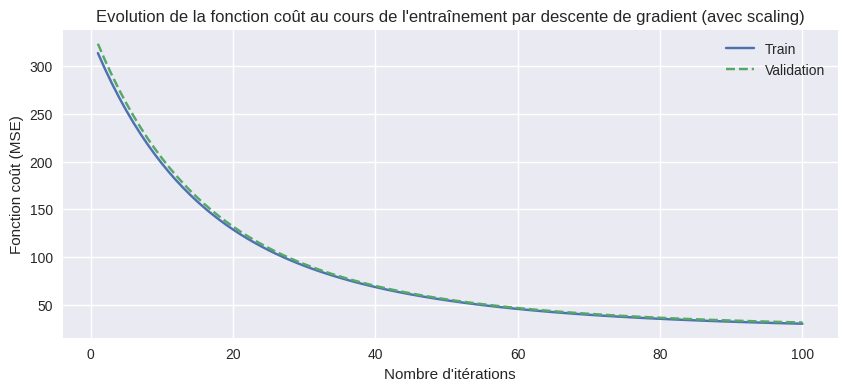

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(history['Iter'], history['MSE'], label="Train")
plt.plot(history['Iter'], history['MSE_val'], label="Validation", linestyle='--')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction coût (MSE)")
plt.title("Evolution de la fonction coût au cours de l'entraînement par descente de gradient (avec scaling)")
plt.legend()
plt.show()

Si on ne scale pas les données, on peut se retrouver avec une loss qui explose :    

In [13]:
history = train_linear_regression(X, y, X_val, y_val, nb_iter=50, learning_rate=0.01)

Iteration n°1, MSE : 15064.675526175948, RMSE : 122.7382398691457
Iteration n°2, MSE : 239514598.58824742, RMSE : 15476.259192332216
Iteration n°3, MSE : 3847844235873.0894, RMSE : 1961592.270547855
Iteration n°4, MSE : 6.181749270108593e+16, RMSE : 248631238.38545695
...
Iteration n°47, MSE : 4.4111367282387824e+197, RMSE : 6.641638900330838e+98
Iteration n°48, MSE : 7.086706601097107e+201, RMSE : 8.418257896439801e+100
Iteration n°49, MSE : 1.138514028108238e+206, RMSE : 1.0670117281961985e+103
Iteration n°50, MSE : 1.829078393055779e+210, RMSE : 1.3524342472208322e+105


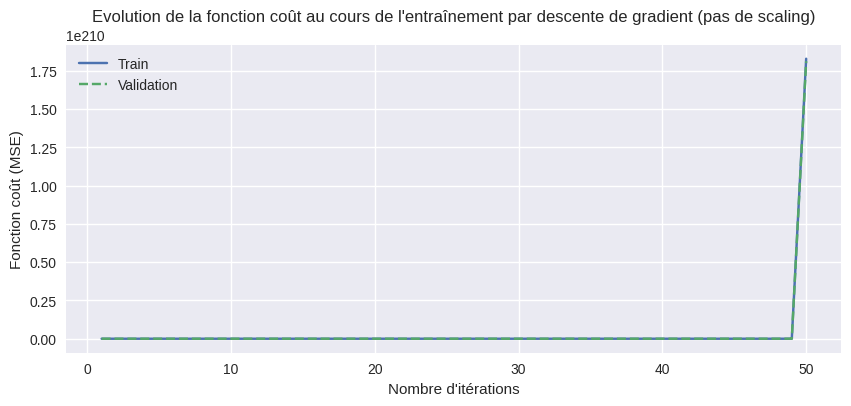

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(history['Iter'], history['MSE'], label="Train")
plt.plot(history['Iter'], history['MSE_val'], label="Validation", linestyle='--')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction coût (MSE)")
plt.title("Evolution de la fonction coût au cours de l'entraînement par descente de gradient (pas de scaling)")
plt.legend()
plt.show()

Si les valeurs de $X$ sont grandes (c'est à dire non scalées), le gradient sera également grand.

Si le gradient est grand, même un petit `learning_rate` provoquera un ajustement gigantesque, ce qui mènera à la divergence.

En baissant le learning rate :

In [15]:
history = train_linear_regression(X, y, X_val, y_val, nb_iter=50, learning_rate=0.0001)

Iteration n°1, MSE : 15064.675526175948, RMSE : 122.7382398691457
Iteration n°2, MSE : 1290.5774618910805, RMSE : 35.92460802696503
Iteration n°3, MSE : 219.38802686530545, RMSE : 14.811752997714533
Iteration n°4, MSE : 128.0354277791652, RMSE : 11.315274092091856
...
Iteration n°47, MSE : 56.47747996762908, RMSE : 7.515150029615449
Iteration n°48, MSE : 56.16750240086283, RMSE : 7.494498142028112
Iteration n°49, MSE : 55.86233161681841, RMSE : 7.474110757596412
Iteration n°50, MSE : 55.56181823592715, RMSE : 7.453980026531273


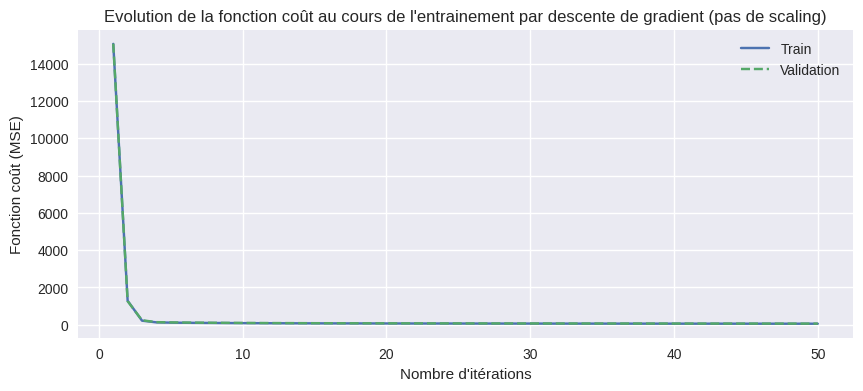

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(history['Iter'], history['MSE'], label="Train")
plt.plot(history['Iter'], history['MSE_val'], label="Validation", linestyle='--')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction coût (MSE)")
plt.title("Evolution de la fonction coût au cours de l'entrainement par descente de gradient (pas de scaling)")
plt.legend()
plt.show()

#### Nouvelle prédiction à partir du modèle entrainé

In [17]:
history = train_linear_regression(X_scaled, y, X_val_scaled, y_val, nb_iter=100, learning_rate=0.01)

Iteration n°1, MSE : 313.7781521999387, RMSE : 17.713784242785014
Iteration n°2, MSE : 297.0772738888795, RMSE : 17.23592973671219
Iteration n°3, MSE : 281.5082398779469, RMSE : 16.77820729034979
Iteration n°4, MSE : 266.9869236170664, RMSE : 16.33973450264925
...
Iteration n°97, MSE : 30.62037996121602, RMSE : 5.533568465395184
Iteration n°98, MSE : 30.423987505183035, RMSE : 5.515794367557862
Iteration n°99, MSE : 30.233937736005288, RMSE : 5.498539600294363
Iteration n°100, MSE : 30.05001141676821, RMSE : 5.48178907080236


In [23]:
final_weights = history['Weights'][-1]
print("Meilleurs paramètres du modèle :", final_weights)

new_X_value = np.array([60, 35, 30])
new_X_scaled = (new_X_value - np.mean(X)) / np.std(X)
print("Nouvelle feature x:", new_X_value)
print("Nouvelle feature x scalée:", new_X_scaled)

prediction = new_X_scaled.dot(final_weights)
print("Prédiction :", prediction)

Meilleurs paramètres du modèle : [ 8.24999002 -5.66189356 -9.07621749]
Nouvelle feature x: [60 35 30]
Nouvelle feature x scalée: [ 0.76183602 -0.16723872 -0.35305367]
Prédiction : 10.436419374350411


In [19]:
train_rmse = np.sqrt(np.mean((X_scaled.dot(final_weights) - y)**2))
train_rmse

np.float64(5.48178907080236)

In [20]:
val_rmse = np.sqrt(np.mean((X_val_scaled.dot(final_weights) - y_val)**2))
val_rmse

np.float64(5.601170110690126)